In [105]:
import logging

import data_utils as du
import evaluation as ev
from naive_bayes import NaiveBayesClassifier
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO)

%matplotlib notebook

In [2]:
NEG_FILE_LIST = du.load_data('NEG')
POS_FILE_LIST = du.load_data('POS')

neg_train_data = NEG_FILE_LIST[:900]
neg_test_data = NEG_FILE_LIST[900:]

pos_train_data = POS_FILE_LIST[:900]
pos_test_data = POS_FILE_LIST[900:]

training_data = {"pos": pos_train_data, "neg": neg_train_data}
test_data = neg_test_data + pos_test_data
test_targets = [0 for _ in range(len(neg_test_data))] +  [1 for _ in range(len(pos_test_data))]
test_targets[:2] + test_targets[100:102]

INFO:data_utils:Successfully read 1000 NEG files
INFO:data_utils:Successfully read 1000 POS files


[0, 0, 1, 1]

In [3]:
def eval_nb(training_data, test_data, models, smoothing=0):
    nb = NaiveBayesClassifier(models=models, smoothing=smoothing)
    nb.train(training_data)
    
    return nb.predict(test_data)
    

## Unsmoothed model

In [4]:
predictions = eval_nb(training_data, test_data, models=[(1, 4)], smoothing=0)
np.mean(predictions == test_targets)

INFO:naive_bayes:Created Naive Bayes classifer with: models=[(1, 4)], smoothing=0


0.825

In [5]:
predictions = eval_nb(training_data, test_data, models=[(2, 7)], smoothing=0)
np.mean(predictions == test_targets)

INFO:naive_bayes:Created Naive Bayes classifer with: models=[(2, 7)], smoothing=0


0.76

In [6]:
predictions = eval_nb(training_data, test_data, models=[(1, 4), (2, 7)], smoothing=0)
np.mean(predictions == test_targets)

INFO:naive_bayes:Created Naive Bayes classifer with: models=[(1, 4), (2, 7)], smoothing=0


0.81

## Smoothed model

In [7]:
predictionsA = eval_nb(training_data, test_data, models=[(1, 4)], smoothing=1)
np.mean(predictionsA == test_targets)

INFO:naive_bayes:Created Naive Bayes classifer with: models=[(1, 4)], smoothing=1


0.825

In [8]:
predictionsB = eval_nb(training_data, test_data, models=[(2, 7)], smoothing=1)
np.mean(predictionsB == test_targets)

INFO:naive_bayes:Created Naive Bayes classifer with: models=[(2, 7)], smoothing=1


0.755

In [10]:
predictions = eval_nb(training_data, test_data, models=[(1, 4), (2, 7)], smoothing=1)
np.mean(predictions == test_targets)

INFO:naive_bayes:Created Naive Bayes classifer with: models=[(1, 4), (2, 7)], smoothing=1


0.835

In [12]:
# # Study how smoothing affects acc

# smoothing_accs = []
# log_smoothings = np.linspace(-7, 4, 30)
# smoothings = np.power(10, log_smoothings)

# for smoothing in tqdm(smoothings, "Computing smoothing accuracies"):
#     predictions = eval_nb(training_data, test_data, models=[(1, 4)], smoothing=smoothing)
#     smoothing_accs.append(np.mean(predictions == test_targets))
# smoothing_accs

In [13]:
# from matplotlib.pyplot import figure

# figure(num=None, figsize=(10, 4), dpi=80, facecolor='w', edgecolor='k')
# plt.plot(log_smoothings, smoothing_accs)
# plt.ylabel('Accuracy')
# plt.xlabel('Log smoothing value')
# plt.show()

## Compare models

In [15]:
model_smooth = [
    ([(1, 4)], 0), ([(1, 4)], 1),
    ([(2, 7)], 0), ([(2, 7)], 1),
    ([(1, 4), (2, 7)], 0), ([(1, 4), (2, 7)], 1)
]
p_vals = np.zeros((6, 6))
accs = np.zeros(6)
for i, (modelA, smoothA) in tqdm(enumerate(model_smooth), "Going over i axis"):
    predictionsA = eval_nb(training_data, test_data, models=modelA, smoothing=smoothA)
    accA = np.mean(predictionsA == test_targets)
    accs[i] = accA
    for j, (modelB, smoothB) in enumerate(model_smooth):
        predictionsB = eval_nb(training_data, test_data, models=modelB, smoothing=smoothB)
        p_value = ev.sign_test(predictionsA, predictionsB, test_targets)
        
        p_vals[i, j] = p_value

print(accs)
print(p_vals)

## Round Robin


In [17]:
def get_rr_folds(neg_file_list=NEG_FILE_LIST, pos_file_list=POS_FILE_LIST):
    neg_folds = [neg_file_list[k::10] for k in range(10)]
    pos_folds = [pos_file_list[k::10] for k in range(10)]
    
    return neg_folds, pos_folds


def nb_process_fold_k(neg_folds, pos_folds, k):
    neg_train_data = [file for fold in (neg_folds[:k] + neg_folds[k + 1:]) for file in fold]
    neg_test_data = neg_folds[k]

    pos_train_data = [file for fold in (pos_folds[:k] + pos_folds[k + 1:]) for file in fold]
    pos_test_data = pos_folds[k]

    training_data = {"pos": pos_train_data, "neg": neg_train_data}
    test_data = neg_test_data + pos_test_data
    test_targets = [0 for _ in range(len(neg_test_data))] +  [1 for _ in range(len(pos_test_data))]

    return training_data, test_data, test_targets


def get_cv_accs(model,  neg_folds, pos_folds, smoothing=0):
    accuracies = []
    for k in range(len(neg_folds)):
        training_data, test_data, test_targets = nb_process_fold_k(neg_folds=neg_folds, pos_folds=pos_folds, k=k)
        predictions = eval_nb(training_data, test_data, models=model, smoothing=smoothing)
        accuracy = np.mean(predictions == test_targets)
        accuracies.append(accuracy)

    return accuracies

In [18]:
neg_folds, pos_folds = get_rr_folds()

In [21]:
# Compute the accuracy list for the models
logging.getLogger().setLevel(logging.CRITICAL)
compared_models = [
    ([(1, 4)], 0), 
    ([(2, 7)], 0), 
    ([(1, 4), (2, 7)], 0),
    ([(1, 4)], 1), 
    ([(2, 7)], 1),
    ([(1, 4), (2, 7)], 1)
]
nb_accs = list()
for i, (model, smooth) in enumerate(compared_models):
    accuracies = get_cv_accs(model=model, smoothing=smooth, neg_folds=neg_folds,
                                                       pos_folds=pos_folds)
    nb_accs.append(accuracies)
    print("For {0} sm {1} : \n\t {2} \n\t Variance {3}".format(model, smooth, accuracies, np.var(accuracies)))

print(nb_accs)

For [(1, 4)] sm 0 : 
	 [0.765, 0.82, 0.775, 0.835, 0.78, 0.82, 0.82, 0.785, 0.835, 0.82] 
	 Variance 0.0006222499999999986
For [(2, 7)] sm 0 : 
	 [0.7, 0.715, 0.755, 0.79, 0.675, 0.725, 0.765, 0.77, 0.77, 0.73] 
	 Variance 0.0011922500000000006
For [(1, 4), (2, 7)] sm 0 : 
	 [0.765, 0.815, 0.77, 0.815, 0.74, 0.845, 0.79, 0.805, 0.82, 0.805] 
	 Variance 0.0008659999999999993
For [(1, 4)] sm 1 : 
	 [0.76, 0.835, 0.79, 0.835, 0.77, 0.83, 0.81, 0.78, 0.815, 0.815] 
	 Variance 0.0006739999999999988
For [(2, 7)] sm 1 : 
	 [0.715, 0.755, 0.755, 0.755, 0.7, 0.785, 0.78, 0.79, 0.755, 0.74] 
	 Variance 0.0007560000000000012
For [(1, 4), (2, 7)] sm 1 : 
	 [0.77, 0.82, 0.765, 0.825, 0.745, 0.82, 0.825, 0.8, 0.835, 0.815] 
	 Variance 0.0008609999999999987
[[0.765, 0.82, 0.775, 0.835, 0.78, 0.82, 0.82, 0.785, 0.835, 0.82], [0.7, 0.715, 0.755, 0.79, 0.675, 0.725, 0.765, 0.77, 0.77, 0.73], [0.765, 0.815, 0.77, 0.815, 0.74, 0.845, 0.79, 0.805, 0.82, 0.805], [0.76, 0.835, 0.79, 0.835, 0.77, 0.83, 0.81, 

In [24]:
# Paired t-test
from scipy.stats import ttest_rel

p_vals = np.zeros((6, 6))
t_stats = np.zeros((6, 6))

for i in range(6):    
    for j in range(6):
        accA = nb_accs[i]
        accB = nb_accs[j]
        t, p = ttest_rel(accA, accB)
        p_vals[i, j] = p
        t_stats[i, j] = t
        
np.set_printoptions(formatter={'float': lambda x: "{0:0.2f}".format(x)})
print(p_vals)
print(t_stats)

[[nan 0.00 0.22 0.69 0.00 0.43]
 [0.00 nan 0.00 0.00 0.14 0.00]
 [0.22 0.00 nan 0.26 0.00 0.33]
 [0.69 0.00 0.26 nan 0.00 0.73]
 [0.00 0.14 0.00 0.00 nan 0.00]
 [0.43 0.00 0.33 0.73 0.00 nan]]
[[nan 6.34 1.33 0.41 5.56 0.83]
 [-6.34 nan -5.30 -5.82 -1.60 -6.60]
 [-1.33 5.30 nan -1.21 6.20 -1.02]
 [-0.41 5.82 1.21 nan 5.71 0.36]
 [-5.56 1.60 -6.20 -5.71 nan -6.19]
 [-0.83 6.60 1.02 -0.36 6.19 nan]]


## SVM BOW

In [28]:
from data_utils import load_untagged_data
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

neg_file_list = load_untagged_data('NEG')
pos_file_list = load_untagged_data('POS')
neg_folds_svm, pos_folds_svm = get_rr_folds(neg_file_list, pos_file_list)

train_data_folds_svm = [neg + pos for neg, pos in zip(neg_folds[1:], pos_folds[1:])]
train_target_folds_svm = [[0 for _ in range(len(neg))] + [1 for _ in range(len(pos))] for neg, pos in zip(neg_folds[1:], pos_folds[1:])]

test_data_svm = neg_folds[0] + pos_folds[0]
test_targets_svm = [0 for _ in range(len(neg_folds[0]))] + [1 for _ in range(len(pos_folds[0]))]

assert(len(train_data_folds_svm) == len(train_target_folds_svm) == 9)
assert(len(test_data_svm) == len(test_targets_svm) == 200)

In [27]:
# Recreate accuracies for NB bc we now use 9 fold
compared_models = [
    ([(1, 4)], 0), 
    ([(2, 7)], 0), 
    ([(1, 4), (2, 7)], 0),
    ([(1, 4)], 1), 
    ([(2, 7)], 1),
    ([(1, 4), (2, 7)], 1)
]
new_nb_accs = list()
for i, (model, smooth) in enumerate(compared_models):
    accuracies = get_cv_accs(model=model, smoothing=smooth, neg_folds=neg_folds[1:],
                                                       pos_folds=pos_folds[1:])
    new_nb_accs.append(accuracies)
print(new_nb_accs)

[[0.795, 0.795, 0.815, 0.77, 0.825, 0.835, 0.76, 0.82, 0.795], [0.745, 0.76, 0.785, 0.69, 0.735, 0.765, 0.77, 0.76, 0.745], [0.825, 0.78, 0.81, 0.745, 0.835, 0.81, 0.795, 0.815, 0.82], [0.825, 0.805, 0.835, 0.775, 0.815, 0.805, 0.77, 0.87, 0.805], [0.755, 0.75, 0.74, 0.695, 0.785, 0.76, 0.77, 0.755, 0.72], [0.81, 0.77, 0.81, 0.74, 0.825, 0.825, 0.78, 0.82, 0.765]]


In [53]:
def get_svm_bow_accs(cv, train_data, train_targets, test_data, test_targets):
    svm_bow = Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('svm', SGDClassifier(loss='hinge', penalty='l2',
                              alpha=1e-3, random_state=42,
                               max_iter=5, tol=None)),
    ])
    
    parameters = {'vect__ngram_range': [(1, 1), (1, 2), (2, 2)],
                  'tfidf__use_idf': (True, False),
                  'svm__alpha': (1e-2, 1e-3)}
    gs_svm_bow = GridSearchCV(svm_bow, parameters, cv=cv, iid=False,  n_jobs=-1)
    gs_svm_bow.fit(train_data, train_targets)
    
    predicted_bow = gs_svm_bow.predict(test_data)
    accuracy = np.mean(predicted_bow == test_targets)
    return accuracy

In [54]:
svm_bow_accuracies = []
for k in tqdm(range(len(train_data_folds_svm)), "Doing CV on SVM BOW"):
    tmp_train_data = [file for fold in (train_data_folds_svm[:k] + train_data_folds_svm[k + 1:]) for file in fold]
    tmp_train_targets = [target for fold in (train_target_folds_svm[:k] + train_target_folds_svm[k + 1:]) for target in fold]

    accuracy = get_svm_bow_accs(cv=8, train_data=tmp_train_data, train_targets=tmp_train_targets, 
                           test_data=train_data_folds_svm[k], test_targets=train_target_folds_svm[k])
    svm_bow_accuracies.append(accuracy)
print(svm_bow_accuracies)
print(np.mean(svm_bow_accuracies))

Doing CV on SVM BOW: 100%|██████████| 9/9 [06:08<00:00, 40.97s/it]

[0.82, 0.835, 0.84, 0.78, 0.845, 0.87, 0.82, 0.87, 0.845]
0.836111111111111


In [55]:
# Significance testing vs NB

bow_nb_p_values = np.zeros(6)
for i, model in enumerate(compared_models):
    accuracy_nb = new_nb_accs[i]
    t, p_val = ttest_rel(accuracy_nb, svm_bow_accuracies)
    bow_nb_p_values[i] = p_val
    print("Comparing with model {0}, {1} return p value {2}".format(model, np.mean(accuracy_nb), p_val))
bow_nb_p_values

Comparing with model ([(1, 4)], 0), 0.8011111111111111 return p value 0.00020803500270744676
Comparing with model ([(2, 7)], 0), 0.7505555555555555 return p value 3.68885298917304e-06
Comparing with model ([(1, 4), (2, 7)], 0), 0.8038888888888889 return p value 0.0021907762972375403
Comparing with model ([(1, 4)], 1), 0.8116666666666666 return p value 0.017415710253860718
Comparing with model ([(2, 7)], 1), 0.7477777777777778 return p value 7.841082172473026e-06
Comparing with model ([(1, 4), (2, 7)], 1), 0.7938888888888889 return p value 0.0003677259651617817


array([0.00, 0.00, 0.00, 0.02, 0.00, 0.00])

In [56]:
# Test on blind set
get_svm_bow_accs(cv=9, train_data=[file for fold in train_data_folds_svm for file in fold],
                 train_targets=[target for fold in train_target_folds_svm for target in fold],
                 test_data=test_data_svm,
                 test_targets=test_targets_svm)

0.815

## Doc2vec

In [58]:
from doc2vec import get_doc2vec_model
from gensim.utils import simple_preprocess
from sklearn.linear_model import SGDClassifier


In [60]:
train_data_folds_d2v = [[simple_preprocess(fl) for fl in fold] for fold in train_data_folds_svm]
train_target_folds_d2v = train_target_folds_svm

test_data_d2v = [simple_preprocess(fl) for fl in test_data_svm]
test_targets_d2v = test_targets_svm

assert(len(train_data_folds_d2v) == len(train_target_folds_d2v) == 9)
assert(len(test_data_d2v) == len(test_targets_d2v) == 200)

In [61]:
def doc2vec_data(doc2vec_model):
    d2v_train_data_folds = [[doc2vec_model.infer_vector(tokens) for tokens in fold] for fold in train_data_folds_d2v]
    d2v_test_data = [doc2vec_model.infer_vector(tokens) for tokens in test_data_d2v]
    
    return d2v_train_data_folds, d2v_test_data

In [67]:
def get_svm_d2v_acc(cv, train_data, train_targets, test_data, test_targets):
    svm_d2v = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42,  max_iter=5, tol=None)
    
    parameters = {'alpha': (1e-2, 1e-3, 1e-4)}
    gs_svm_d2v = GridSearchCV(svm_d2v, parameters, cv=cv, iid=False,  n_jobs=-1)
    gs_svm_d2v.fit(train_data, train_targets)
    
    predicted_d2v = gs_svm_d2v.predict(test_data)
    accuracy = np.mean(predicted_d2v == test_targets)
    return accuracy


def get_d2v_cv_accs(doc2vec):
    # Convert data using doc2vec
    d2v_train_data_folds, _ = doc2vec_data(doc2vec)
    # Compute the 9 accuracy for the folds
    svm_d2v_accs = list()
    
    for k in tqdm(range(len(d2v_train_data_folds)), "Doing CV on SVM Doc2vec"):
        tmp_train_data = [vec for fold in (d2v_train_data_folds[:k] + d2v_train_data_folds[k + 1:]) 
                          for vec in fold]
        tmp_train_targets = [target for fold in (train_target_folds_d2v[:k] + train_target_folds_d2v[k + 1:]) 
                             for target in fold]
        accuracy = get_svm_d2v_acc(cv=8, train_data=tmp_train_data, train_targets=tmp_train_targets, 
                           test_data=d2v_train_data_folds[k], test_targets=train_target_folds_d2v[k])
        
        svm_d2v_accs.append(accuracy)
    return svm_d2v_accs

In [29]:
# doc2vec = get_doc2vec_model()

# train_data_d2v = [doc2vec.infer_vector(tokens) for tokens in preprocessed_train_data]
# test_data_d2v = [doc2vec.infer_vector(tokens) for tokens in preprocessed_test_data]

In [70]:
d2v_accs = dict()

vector_size = 100
dm_concat = 1
min_count = 2
for dm in [0, 1]:
    for context_window in [2, 4]:
        for hierarchical_softmax in [0, 1]:
            for epochs in [10, 20]:
                model_name = "model_{dm}_{vector_size}_{epochs}_{context_window}_{min_count}_{hierarchical_softmax}_{dm_concat}".format(
                    dm=bool(dm), vector_size=vector_size, epochs=epochs, context_window=context_window,
                    min_count=min_count, hierarchical_softmax=hierarchical_softmax, dm_concat=dm_concat)
                
                print("Processing model {}".format(model_name))

                tmp_doc2vec = get_doc2vec_model(dm=dm, vector_size=vector_size, context_window=context_window,
                                  hierarchical_softmax=hierarchical_softmax, dm_concat=dm_concat, epochs=epochs)

                tmp_accs = get_d2v_cv_accs(tmp_doc2vec)
                d2v_accs[model_name] = tmp_accs


Processing model model_False_100_10_2_2_0_1


Doing CV on SVM Doc2vec: 100%|██████████| 9/9 [00:15<00:00,  1.70s/it]


Processing model model_False_100_20_2_2_0_1


Doing CV on SVM Doc2vec: 100%|██████████| 9/9 [00:15<00:00,  1.72s/it]


Processing model model_False_100_10_2_2_1_1


Doing CV on SVM Doc2vec: 100%|██████████| 9/9 [00:15<00:00,  1.74s/it]


Processing model model_False_100_20_2_2_1_1


Doing CV on SVM Doc2vec: 100%|██████████| 9/9 [00:15<00:00,  1.72s/it]


Processing model model_False_100_10_4_2_0_1


Doing CV on SVM Doc2vec: 100%|██████████| 9/9 [00:15<00:00,  1.77s/it]


Processing model model_False_100_20_4_2_0_1


Doing CV on SVM Doc2vec: 100%|██████████| 9/9 [00:15<00:00,  1.70s/it]


Processing model model_False_100_10_4_2_1_1


Doing CV on SVM Doc2vec: 100%|██████████| 9/9 [00:15<00:00,  1.72s/it]


Processing model model_False_100_20_4_2_1_1


Doing CV on SVM Doc2vec: 100%|██████████| 9/9 [00:15<00:00,  1.76s/it]


Processing model model_True_100_10_2_2_0_1


Doing CV on SVM Doc2vec: 100%|██████████| 9/9 [00:15<00:00,  1.77s/it]


Processing model model_True_100_20_2_2_0_1


Doing CV on SVM Doc2vec: 100%|██████████| 9/9 [00:15<00:00,  1.75s/it]


Processing model model_True_100_10_2_2_1_1


Doing CV on SVM Doc2vec: 100%|██████████| 9/9 [00:15<00:00,  1.76s/it]


Processing model model_True_100_20_2_2_1_1


Doing CV on SVM Doc2vec: 100%|██████████| 9/9 [00:15<00:00,  1.72s/it]


Processing model model_True_100_10_4_2_0_1


Doing CV on SVM Doc2vec: 100%|██████████| 9/9 [00:15<00:00,  1.73s/it]


Processing model model_True_100_20_4_2_0_1


Doing CV on SVM Doc2vec: 100%|██████████| 9/9 [00:16<00:00,  1.82s/it]


Processing model model_True_100_10_4_2_1_1


Doing CV on SVM Doc2vec: 100%|██████████| 9/9 [00:16<00:00,  1.79s/it]


Processing model model_True_100_20_4_2_1_1


Doing CV on SVM Doc2vec: 100%|██████████| 9/9 [00:16<00:00,  1.87s/it]

Model model_False_100_10_2_2_0_1 got accs 
	[0.895, 0.82, 0.91, 0.87, 0.885, 0.91, 0.9, 0.91, 0.88]
Model model_False_100_20_2_2_0_1 got accs 
	[0.885, 0.845, 0.92, 0.875, 0.885, 0.9, 0.895, 0.89, 0.865]


In [71]:
for model, accs in d2v_accs.items():
    print("Model {0} got accs \n\t{1}".format(model, accs))

Model model_False_100_10_2_2_0_1 got accs 
	[0.895, 0.82, 0.91, 0.87, 0.885, 0.91, 0.9, 0.91, 0.88]
Model model_False_100_20_2_2_0_1 got accs 
	[0.885, 0.845, 0.92, 0.875, 0.885, 0.9, 0.895, 0.89, 0.865]
Model model_False_100_10_2_2_1_1 got accs 
	[0.86, 0.86, 0.915, 0.87, 0.855, 0.895, 0.865, 0.845, 0.885]
Model model_False_100_20_2_2_1_1 got accs 
	[0.895, 0.85, 0.905, 0.855, 0.86, 0.91, 0.875, 0.86, 0.905]
Model model_False_100_10_4_2_0_1 got accs 
	[0.88, 0.86, 0.895, 0.885, 0.85, 0.925, 0.865, 0.865, 0.875]
Model model_False_100_20_4_2_0_1 got accs 
	[0.895, 0.845, 0.925, 0.88, 0.87, 0.915, 0.895, 0.89, 0.87]
Model model_False_100_10_4_2_1_1 got accs 
	[0.88, 0.86, 0.925, 0.88, 0.86, 0.9, 0.865, 0.845, 0.895]
Model model_False_100_20_4_2_1_1 got accs 
	[0.865, 0.85, 0.875, 0.865, 0.875, 0.905, 0.875, 0.845, 0.865]
Model model_True_100_10_2_2_0_1 got accs 
	[0.765, 0.75, 0.82, 0.78, 0.715, 0.805, 0.83, 0.855, 0.825]
Model model_True_100_20_2_2_0_1 got accs 
	[0.84, 0.805, 0.85, 0.8

In [78]:
# compare the models between them
model_accs = sorted(d2v_accs.items(), key=lambda tup: tup[0])
names_d2v = [t[0] for t in model_accs]
accuracies_d2v = [t[1] for t in model_accs]

def compare_models_ttest_help(i, j):
    # Compare models i and j
    print("{0} and {1}".format(names_d2v[i], names_d2v[j]))
    print("{0} and {1}".format(np.mean(accuracies_d2v[i]), np.mean(accuracies_d2v[j])))
    print("P-val {}\n".format(ttest_rel(accuracies_d2v[i], accuracies_d2v[j])[1]))
names_d2v

['model_False_100_10_2_2_0_1',
 'model_False_100_10_2_2_1_1',
 'model_False_100_10_4_2_0_1',
 'model_False_100_10_4_2_1_1',
 'model_False_100_20_2_2_0_1',
 'model_False_100_20_2_2_1_1',
 'model_False_100_20_4_2_0_1',
 'model_False_100_20_4_2_1_1',
 'model_True_100_10_2_2_0_1',
 'model_True_100_10_2_2_1_1',
 'model_True_100_10_4_2_0_1',
 'model_True_100_10_4_2_1_1',
 'model_True_100_20_2_2_0_1',
 'model_True_100_20_2_2_1_1',
 'model_True_100_20_4_2_0_1',
 'model_True_100_20_4_2_1_1']

In [79]:
# Train Algo
for i in range(8):
    compare_models_ttest_help(i, i + 8)

model_False_100_10_2_2_0_1 and model_True_100_10_2_2_0_1
0.8866666666666666 and 0.793888888888889
P-val 7.830968445064855e-05

model_False_100_10_2_2_1_1 and model_True_100_10_2_2_1_1
0.8722222222222222 and 0.8177777777777778
P-val 2.2329270284121808e-05

model_False_100_10_4_2_0_1 and model_True_100_10_4_2_0_1
0.8777777777777778 and 0.7705555555555555
P-val 8.624499696569466e-05

model_False_100_10_4_2_1_1 and model_True_100_10_4_2_1_1
0.8788888888888889 and 0.7822222222222223
P-val 6.117624244052059e-05

model_False_100_20_2_2_0_1 and model_True_100_20_2_2_0_1
0.8844444444444446 and 0.8377777777777778
P-val 0.0001694460357026987

model_False_100_20_2_2_1_1 and model_True_100_20_2_2_1_1
0.8794444444444445 and 0.8194444444444444
P-val 2.0747526881849835e-05

model_False_100_20_4_2_0_1 and model_True_100_20_4_2_0_1
0.8872222222222222 and 0.7877777777777778
P-val 3.047723646161856e-05

model_False_100_20_4_2_1_1 and model_True_100_20_4_2_1_1
0.8688888888888889 and 0.8044444444444444
P-va

In [80]:
# Epoch comparison
for i in [0, 1, 2, 3, 8, 9, 10, 11]:
    compare_models_ttest_help(i, i + 4)

model_False_100_10_2_2_0_1 and model_False_100_20_2_2_0_1
0.8866666666666666 and 0.8844444444444446
P-val 0.6453763092278234

model_False_100_10_2_2_1_1 and model_False_100_20_2_2_1_1
0.8722222222222222 and 0.8794444444444445
P-val 0.22336850272995862

model_False_100_10_4_2_0_1 and model_False_100_20_4_2_0_1
0.8777777777777778 and 0.8872222222222222
P-val 0.1562194101283687

model_False_100_10_4_2_1_1 and model_False_100_20_4_2_1_1
0.8788888888888889 and 0.8688888888888889
P-val 0.1836981140115602

model_True_100_10_2_2_0_1 and model_True_100_20_2_2_0_1
0.793888888888889 and 0.8377777777777778
P-val 0.003543040828418822

model_True_100_10_2_2_1_1 and model_True_100_20_2_2_1_1
0.8177777777777778 and 0.8194444444444444
P-val 0.8779067304554031

model_True_100_10_4_2_0_1 and model_True_100_20_4_2_0_1
0.7705555555555555 and 0.7877777777777778
P-val 0.14642378855471966

model_True_100_10_4_2_1_1 and model_True_100_20_4_2_1_1
0.7822222222222223 and 0.8044444444444444
P-val 0.076540964054555

In [81]:
#Context Window
for i in [0, 1, 4, 5, 8, 9, 12, 13]:
    compare_models_ttest_help(i, i + 2)

model_False_100_10_2_2_0_1 and model_False_100_10_4_2_0_1
0.8866666666666666 and 0.8777777777777778
P-val 0.36939893698963283

model_False_100_10_2_2_1_1 and model_False_100_10_4_2_1_1
0.8722222222222222 and 0.8788888888888889
P-val 0.01646609889967395

model_False_100_20_2_2_0_1 and model_False_100_20_4_2_0_1
0.8844444444444446 and 0.8872222222222222
P-val 0.34659350708733416

model_False_100_20_2_2_1_1 and model_False_100_20_4_2_1_1
0.8794444444444445 and 0.8688888888888889
P-val 0.13903156810031858

model_True_100_10_2_2_0_1 and model_True_100_10_4_2_0_1
0.793888888888889 and 0.7705555555555555
P-val 0.06591594381469915

model_True_100_10_2_2_1_1 and model_True_100_10_4_2_1_1
0.8177777777777778 and 0.7822222222222223
P-val 0.030707772642940417

model_True_100_20_2_2_0_1 and model_True_100_20_4_2_0_1
0.8377777777777778 and 0.7877777777777778
P-val 0.003998937094453863

model_True_100_20_2_2_1_1 and model_True_100_20_4_2_1_1
0.8194444444444444 and 0.8044444444444444
P-val 0.1035018531

In [82]:
# Hierarchical softmax
for i in range(0, 16, 2):
    compare_models_ttest_help(i, i + 1)

model_False_100_10_2_2_0_1 and model_False_100_10_2_2_1_1
0.8866666666666666 and 0.8722222222222222
P-val 0.19664163404464927

model_False_100_10_4_2_0_1 and model_False_100_10_4_2_1_1
0.8777777777777778 and 0.8788888888888889
P-val 0.8533523615902356

model_False_100_20_2_2_0_1 and model_False_100_20_2_2_1_1
0.8844444444444446 and 0.8794444444444445
P-val 0.5286566248481263

model_False_100_20_4_2_0_1 and model_False_100_20_4_2_1_1
0.8872222222222222 and 0.8688888888888889
P-val 0.025058924329904007

model_True_100_10_2_2_0_1 and model_True_100_10_2_2_1_1
0.793888888888889 and 0.8177777777777778
P-val 0.05130728646955113

model_True_100_10_4_2_0_1 and model_True_100_10_4_2_1_1
0.7705555555555555 and 0.7822222222222223
P-val 0.41480951262040644

model_True_100_20_2_2_0_1 and model_True_100_20_2_2_1_1
0.8377777777777778 and 0.8194444444444444
P-val 0.19001106564117676

model_True_100_20_4_2_0_1 and model_True_100_20_4_2_1_1
0.7877777777777778 and 0.8044444444444444
P-val 0.1016323903811

In [83]:
# Compare model to NB and svm_bow
represent_d2v_accs = accuracies_d2v[0]

print("BOW vs D2v pval: {}".format(ttest_rel(represent_d2v_accs, svm_bow_accuracies)[1]))

d2v_nb_p_values = np.zeros(6)
for i, model in enumerate(compared_models):
    accuracy_nb = new_nb_accs[i]
    t, p_val = ttest_rel(accuracy_nb, represent_d2v_accs)
    d2v_nb_p_values[i] = p_val
    print("Comparing with model {0}, {1} return p value {2}".format(model, np.mean(accuracy_nb), p_val))
d2v_nb_p_values

BOW vs D2v pval: 0.0015088735221704555
Comparing with model ([(1, 4)], 0), 0.8011111111111111 return p value 3.798197182166406e-05
Comparing with model ([(2, 7)], 0), 0.7505555555555555 return p value 1.5711840463515102e-06
Comparing with model ([(1, 4), (2, 7)], 0), 0.8038888888888889 return p value 2.4945306799099176e-05
Comparing with model ([(1, 4)], 1), 0.8116666666666666 return p value 0.0001633486412100546
Comparing with model ([(2, 7)], 1), 0.7477777777777778 return p value 1.974343827371844e-06
Comparing with model ([(1, 4), (2, 7)], 1), 0.7938888888888889 return p value 6.228123434097694e-06


array([0.00, 0.00, 0.00, 0.00, 0.00, 0.00])

In [86]:
repr_doc2vec = get_doc2vec_model(dm=0, vector_size=100, context_window=2,
                                  hierarchical_softmax=0, dm_concat=1, epochs=10)
d2v_train_data_folds, d2v_test_data = doc2vec_data(repr_doc2vec)
flat_d2v_train_data = [vec for fold in d2v_train_data_folds for vec in fold]
flat_d2v_train_target = [target for fold in train_target_folds_svm for target in fold]
get_svm_d2v_acc(cv=9, 
                train_data=flat_d2v_train_data,
                train_targets=flat_d2v_train_target,
                test_data=d2v_test_data,
                test_targets=test_targets_d2v)

0.865

### SVM d2v Permutation tests

In [34]:
import random

def permutation_test(predA, predB, targets, R=10000):
    correctA = (predA == targets)
    correctB = (predB == targets)
    og_diff = abs(np.mean(correctA) - np.mean(correctB))
    
    tmpA = predA.copy()
    tmpB = predB.copy()
    s = 0
    for _ in range(R):
        for i in range(len(predA)):
            flip = random.randint(0, 1)
            if flip == 0:
                tmpA[i] = predA[i]
                tmpB[i] = predB[i]
            else:
                tmpA[i] = predB[i]
                tmpB[i] = predA[i]
        tmp_correctA = (tmpA == targets)
        tmp_correctB = (tmpB == targets)
        diff = abs(np.mean(tmp_correctA) - np.mean(tmp_correctB))
        if diff >= og_diff:
            s += 1
    return (s + 1 ) / (R + 1) 

In [35]:
m_p = sorted(results.items(), key=lambda tup: tup[0])
names = [t[0] for t in m_p]
preds = [t[1] for t in m_p]
accs = [np.mean(t[1] == test_target_d2v) for t in m_p]

def helper_print(i, offset):
    print("{0} and {1}".format(names[i], names[i + offset]))
    print("{0} and {1}".format(accs[i], accs[i + offset]))
    print("P-val {}\n".format(permutation_test(preds[i], preds[i + offset], test_target_d2v)))
names

['model_False_100_10_2_2_0_1',
 'model_False_100_10_2_2_1_1',
 'model_False_100_10_4_2_0_1',
 'model_False_100_10_4_2_1_1',
 'model_False_100_20_2_2_0_1',
 'model_False_100_20_2_2_1_1',
 'model_False_100_20_4_2_0_1',
 'model_False_100_20_4_2_1_1',
 'model_True_100_10_2_2_0_1',
 'model_True_100_10_2_2_1_1',
 'model_True_100_10_4_2_0_1',
 'model_True_100_10_4_2_1_1',
 'model_True_100_20_2_2_0_1',
 'model_True_100_20_2_2_1_1',
 'model_True_100_20_4_2_0_1',
 'model_True_100_20_4_2_1_1']

In [36]:
# Train Algo
diffs = []
for i in range(8):
    helper_print(i, 8)
    diffs = [accs[i] - accs[i + 8]]
np.mean(diffs)

model_False_100_10_2_2_0_1 and model_True_100_10_2_2_0_1
0.845 and 0.755
P-val 0.008599140085991401

model_False_100_10_2_2_1_1 and model_True_100_10_2_2_1_1
0.835 and 0.755
P-val 0.007499250074992501

model_False_100_10_4_2_0_1 and model_True_100_10_4_2_0_1
0.85 and 0.705
P-val 9.999000099990002e-05

model_False_100_10_4_2_1_1 and model_True_100_10_4_2_1_1
0.815 and 0.695
P-val 0.00029997000299970003

model_False_100_20_2_2_0_1 and model_True_100_20_2_2_0_1
0.84 and 0.795
P-val 0.0963903609639036

model_False_100_20_2_2_1_1 and model_True_100_20_2_2_1_1
0.82 and 0.76
P-val 0.067993200679932

model_False_100_20_4_2_0_1 and model_True_100_20_4_2_0_1
0.845 and 0.755
P-val 0.0017998200179982

model_False_100_20_4_2_1_1 and model_True_100_20_4_2_1_1
0.82 and 0.72
P-val 0.0007999200079992001



0.09999999999999998

In [37]:
# Epoch comparison
for i in [0, 1, 2, 3, 8, 9, 10, 11]:
    helper_print(i, 4)

model_False_100_10_2_2_0_1 and model_False_100_20_2_2_0_1
0.845 and 0.84
P-val 1.0

model_False_100_10_2_2_1_1 and model_False_100_20_2_2_1_1
0.835 and 0.82
P-val 0.6028397160283971

model_False_100_10_4_2_0_1 and model_False_100_20_4_2_0_1
0.85 and 0.845
P-val 1.0

model_False_100_10_4_2_1_1 and model_False_100_20_4_2_1_1
0.815 and 0.82
P-val 1.0

model_True_100_10_2_2_0_1 and model_True_100_20_2_2_0_1
0.755 and 0.795
P-val 0.24447555244475552

model_True_100_10_2_2_1_1 and model_True_100_20_2_2_1_1
0.755 and 0.76
P-val 1.0

model_True_100_10_4_2_0_1 and model_True_100_20_4_2_0_1
0.705 and 0.755
P-val 0.14028597140285973

model_True_100_10_4_2_1_1 and model_True_100_20_4_2_1_1
0.695 and 0.72
P-val 0.49865013498650135



In [38]:
#Context Window
for i in [0, 1, 4, 5, 8, 9, 12, 13]:
    helper_print(i, 2)

model_False_100_10_2_2_0_1 and model_False_100_10_4_2_0_1
0.845 and 0.85
P-val 1.0

model_False_100_10_2_2_1_1 and model_False_100_10_4_2_1_1
0.835 and 0.815
P-val 0.34356564343565643

model_False_100_20_2_2_0_1 and model_False_100_20_4_2_0_1
0.84 and 0.845
P-val 1.0

model_False_100_20_2_2_1_1 and model_False_100_20_4_2_1_1
0.82 and 0.82
P-val 1.0

model_True_100_10_2_2_0_1 and model_True_100_10_4_2_0_1
0.755 and 0.705
P-val 0.07879212078792121

model_True_100_10_2_2_1_1 and model_True_100_10_4_2_1_1
0.755 and 0.695
P-val 0.0428957104289571

model_True_100_20_2_2_0_1 and model_True_100_20_4_2_0_1
0.795 and 0.755
P-val 0.11378862113788621

model_True_100_20_2_2_1_1 and model_True_100_20_4_2_1_1
0.76 and 0.72
P-val 0.15758424157584242



In [39]:
# Hierarchical softmax
for i in range(0, 16, 2):
    helper_print(i, 1)

model_False_100_10_2_2_0_1 and model_False_100_10_2_2_1_1
0.845 and 0.835
P-val 0.7889211078892111

model_False_100_10_4_2_0_1 and model_False_100_10_4_2_1_1
0.85 and 0.815
P-val 0.16698330166983302

model_False_100_20_2_2_0_1 and model_False_100_20_2_2_1_1
0.84 and 0.82
P-val 0.46155384461553844

model_False_100_20_4_2_0_1 and model_False_100_20_4_2_1_1
0.845 and 0.82
P-val 0.39036096390360964

model_True_100_10_2_2_0_1 and model_True_100_10_2_2_1_1
0.755 and 0.755
P-val 1.0

model_True_100_10_4_2_0_1 and model_True_100_10_4_2_1_1
0.705 and 0.695
P-val 0.8788121187881212

model_True_100_20_2_2_0_1 and model_True_100_20_2_2_1_1
0.795 and 0.76
P-val 0.3428657134286571

model_True_100_20_4_2_0_1 and model_True_100_20_4_2_1_1
0.755 and 0.72
P-val 0.3090690930906909



In [40]:
# Compare doc2vec to BOW.
p_vals = []
for i in range(15):
    p_vals.append(permutation_test(preds[0], predicted_svm_bow, test_target_d2v))

p_vals

[0.30046995300469953,
 0.30086991300869914,
 0.298970102989701,
 0.31056894310568944,
 0.30016998300169984,
 0.29527047295270475,
 0.28877112288771123,
 0.28757124287571245,
 0.29017098290170984,
 0.29617038296170384,
 0.298970102989701,
 0.2913708629137086,
 0.29287071292870714,
 0.3057694230576942,
 0.29127087291270876]

# Visualization

In [188]:
vector_size = 100
dm_concat = 1
min_count = 2
dm = 0
context_window = 2
hierarchical_softmax = 0
epochs = 10

doc2vec = get_doc2vec_model(dm=dm, context_window=context_window, hierarchical_softmax=hierarchical_softmax, epochs=10, 
                            min_count=min_count, vector_size=vector_size, dm_concat=dm_concat)

reviewA = simple_preprocess("Amazing movie, loved the beginning.")
reviewB = simple_preprocess("The beginning was the best part, absolutely spectacular.")
reviewC = simple_preprocess("Horrendous movie, hated the ending.")

vectorA = doc2vec.infer_vector(reviewA)
vectorB = doc2vec.infer_vector(reviewB)
vectorC = doc2vec.infer_vector(reviewC)

def vector_diff(a, b):
    return np.sum(np.power(a - b, 2))

print("Difference between A and B: {}".format(vector_diff(vectorA, vectorB)))
print("Difference between A and C: {}".format(vector_diff(vectorA, vectorC)))
print("Difference between B and C: {}".format(vector_diff(vectorB, vectorC)))

Difference between A and B: 0.6009283661842346
Difference between A and C: 0.5885409116744995
Difference between B and C: 0.9360224604606628


## T-SNE

In [190]:
vis_doc2vec = get_doc2vec_model(dm=0, vector_size=50, context_window=2,
                                  hierarchical_softmax=0, dm_concat=1, epochs=10)

d2v_train_data_folds, vis_test_data = doc2vec_data(vis_doc2vec)

vis_train_data = [vec for fold in d2v_train_data_folds for vec in fold]
vis_train_target = [target for fold in train_target_folds_svm for target in fold]

vis_test_target = np.array(test_targets_d2v)


In [191]:
# T-SNE, create a model
from tsne import tsne, pca
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

svm_d2v = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42,  max_iter=5, tol=None)
svm_d2v.fit(vis_train_data, vis_train_target)

svm_d2v_predictions = svm_d2v.predict(vis_test_data)
np.mean(vis_test_target == svm_d2v_predictions)

0.86

### All data

In [219]:
all_data = np.concatenate((vis_train_data, vis_test_data))
all_targets = np.concatenate((vis_train_target, vis_test_target))

neg_indices = (all_targets == 0)
pos_indices = (all_targets == 1)

true_positive = (test_targets_d2v == 1) * (svm_d2v_predictions == 1)
true_negative = (test_targets_d2v == 0) * (svm_d2v_predictions == 0)
false_positive = (test_targets_d2v == 0) * (svm_d2v_predictions == 1)
false_negative = (test_targets_d2v == 1) * (svm_d2v_predictions == 0)

bad_pred_indices = false_positive + false_negative
good_pred_indices = true_positive + true_negatice

all_targets.shape, all_data.shape

((2000,), (2000, 50))

In [261]:
# Plot all the data
tsne_2d = TSNE(n_components=2, perplexity=50, n_iter=10000)
reduced_data_2d = tsne_2d.fit_transform(all_data)


<IPython.core.display.Javascript object>


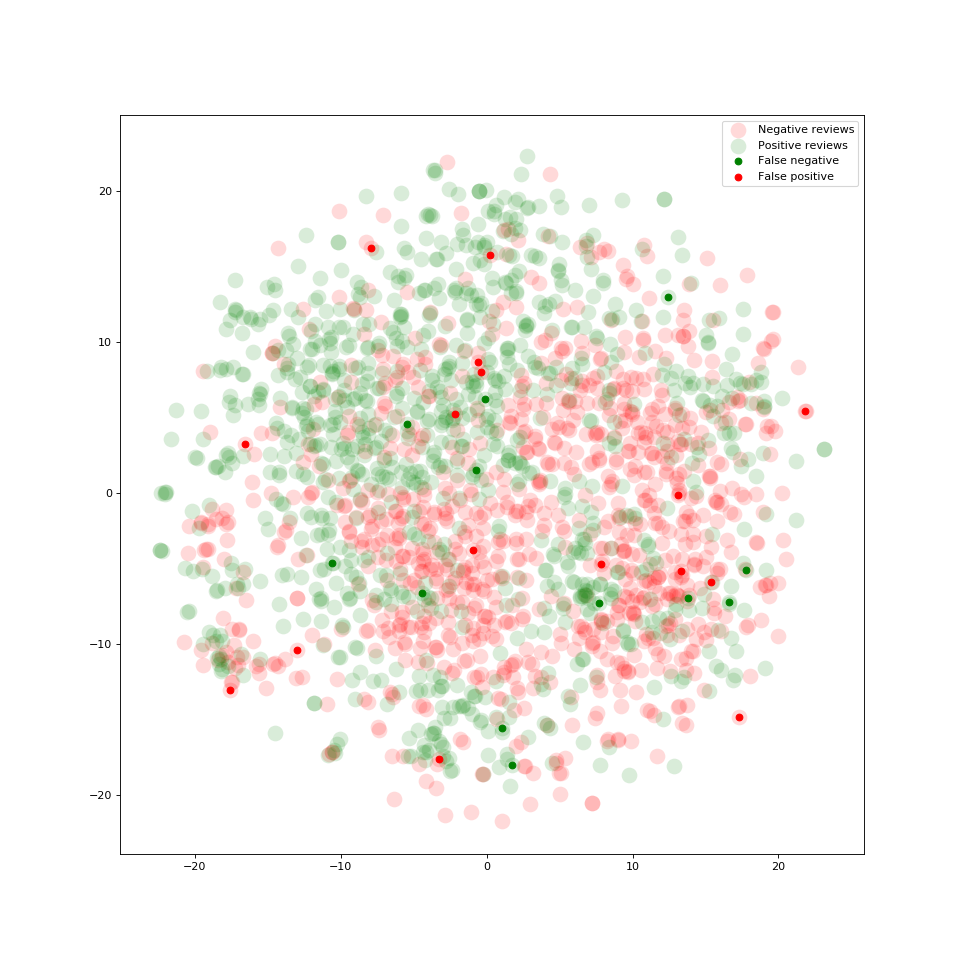

In [262]:
fig = plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')


plt.scatter(reduced_data_2d[neg_indices][:, 0], reduced_data_2d[neg_indices][:, 1], c='r', alpha=0.15, s=200, lw = 0,label="Negative reviews")
plt.scatter(reduced_data_2d[pos_indices][:, 0], reduced_data_2d[pos_indices][:, 1], c='g', alpha=0.15, s=200, lw = 0, label="Positive reviews")

plt.scatter(reduced_data_2d[-200:][false_negative][:, 0], reduced_data_2d[-200:][false_negative][:, 1], c='g', label="False negative")
plt.scatter(reduced_data_2d[-200:][false_positive][:, 0], reduced_data_2d[-200:][false_positive][:, 1], c='r', label="False positive")
# plt.scatter(reduced_data_2d[-200:][good_pred_indices][:, 0], reduced_data_2d[-200:][good_pred_indices][:, 1], c='c', label="Correctly classified points")

plt.legend()
plt.show()

### 3D

In [263]:
# Plot all the data
tsne_3d = TSNE(n_components=3, perplexity=100, n_iter=10000)
reduced_data_3d = tsne_3d.fit_transform(all_data)


<IPython.core.display.Javascript object>


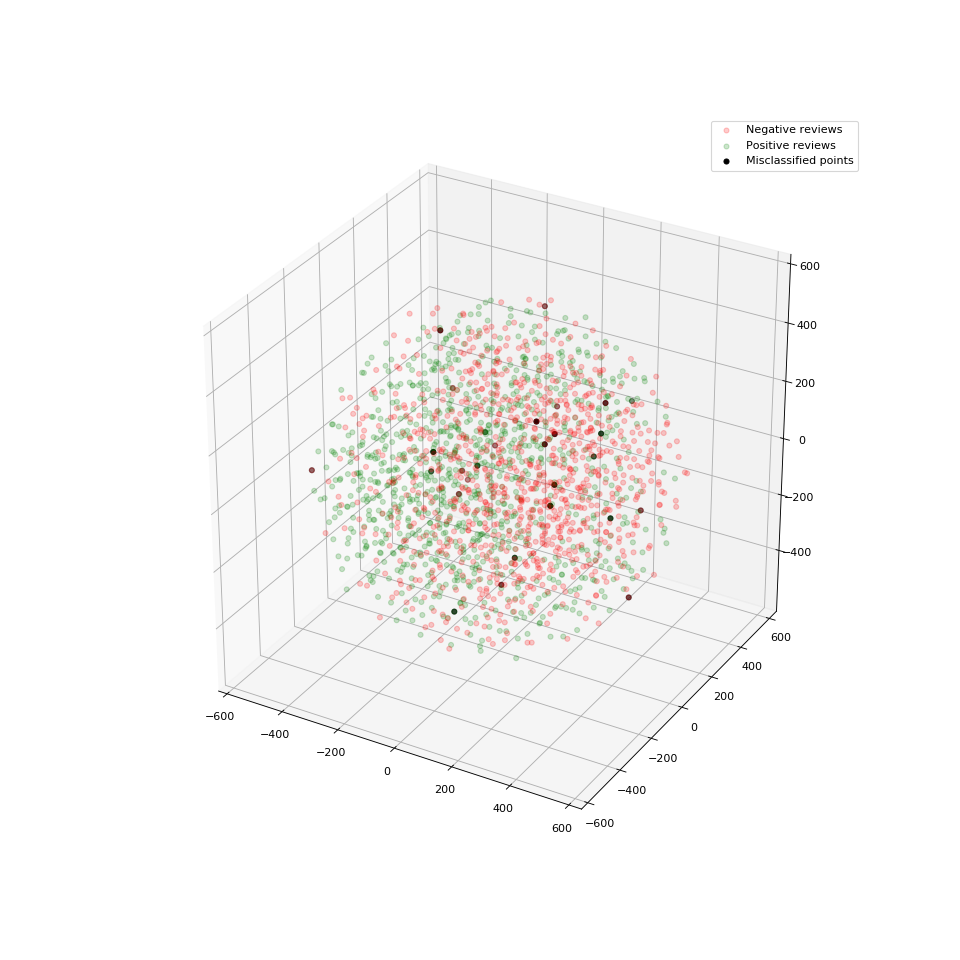

In [264]:
fig = plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111, projection='3d')

ax.scatter(reduced_data_3d[neg_indices][:, 0], reduced_data_3d[neg_indices][:, 1], reduced_data_3d[neg_indices][:, 2], c='r', alpha=0.2, label="Negative reviews")
ax.scatter(reduced_data_3d[pos_indices][:, 0], reduced_data_3d[pos_indices][:, 1], reduced_data_3d[pos_indices][:, 2], c='g', alpha=0.2, label="Positive reviews")

ax.scatter(reduced_data_3d[-200:][bad_pred_indices][:, 0], reduced_data_3d[-200:][bad_pred_indices][:, 1], reduced_data_3d[-200:][bad_pred_indices][:, 2], c='k', label="Misclassified points")

plt.legend()
plt.show()